* **Aluno:** Ygor Souza de Oliveira
* **Disciplina:** Estratégias e Tendências Tecnológias Associadas ao  uso do Big Data
* **Atividade 03:** Utilizando Python e serviço S3 da AWS para trabalhar modelos de *Machine Learning*

#### Tarefas

1. Preparar máquina virtual com JupyterLab, Boto3 e scikit-learn;
1. Criar notebook para:
  1. Salvar base de dados de treino (`train.csv`) utilizando o boto3;
  1. Criar Regressão Logística para classificação de passageiros em sobreviventes e não sobreviventes (utilizar a partição de treino);
    * Você pode usar [esse notebook](https://www.kaggle.com/code/rezvanrah/logistic-regression-titanic) como referência.
  1. Criar um Bucket na S3 para armazenar o modelo pré-treinado (utilizar a ferramenta [Pickle](https://scikit-learn.org/stable/modules/model_persistence.html))
  1. Realizar upload do modelo pré-treinado para esse Bucket;
  1. Tornar o Bucket público;
  1. Distribuir para os outros alunos a URL do bucket contendo o modelo;
1. Criar novo notebook para:
  1. Salvar base de dados de teste (`test.csv`) utilizando o boto3;
  1. Carregar modelo pré-treinado de um dos colegas, utilizando o [Pickle](https://scikit-learn.org/stable/modules/model_persistence.html).
  1. Realizar a predição utilizando a partição de testes.
  1. Realizar a avaliação da [acurácia](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) do modelo pré-treinado

In [ ]:
! pip list | grep boto

boto3                     1.33.6
botocore                  1.33.6


In [ ]:
!pip install boto3

In [ ]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Salvando base de teste**

In [ ]:
!wget -c https://senac2023.s3.amazonaws.com/datasets/titanic/test.csv

--2023-12-03 16:51:02--  https://senac2023.s3.amazonaws.com/datasets/titanic/test.csv
Resolving senac2023.s3.amazonaws.com (senac2023.s3.amazonaws.com)... 52.217.74.225, 54.231.164.41, 16.182.38.81, ...
Connecting to senac2023.s3.amazonaws.com (senac2023.s3.amazonaws.com)|52.217.74.225|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



**Salvando base de treino**

In [ ]:
!wget -c https://senac2023.s3.amazonaws.com/datasets/titanic/train.csv

--2023-12-03 16:51:05--  https://senac2023.s3.amazonaws.com/datasets/titanic/train.csv
Resolving senac2023.s3.amazonaws.com (senac2023.s3.amazonaws.com)... 52.216.77.12, 54.231.164.41, 52.216.138.35, ...
Connecting to senac2023.s3.amazonaws.com (senac2023.s3.amazonaws.com)|52.216.77.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
# Lendo arquivo de treino
train_df= pd.read_csv('./train.csv')

**Sobre os dados**

**PassengerId:** Número de identificação único atribuído a cada passageiro. Este é apenas um identificador sequencial.

**Survived:** Indica se o passageiro sobreviveu ou não ao naufrágio do Titanic. É uma variável binária, onde 1 significa que o passageiro sobreviveu e 0 significa que não sobreviveu.

**Pclass:** Representa a classe do bilhete adquirido pelo passageiro. Pode ser 1 (primeira classe), 2 (segunda classe) ou 3 (terceira classe), refletindo a posição social do passageiro.

**Name:** Nome do passageiro.

**Sex:** Gênero do passageiro, indicando se é masculino ou feminino.

**Age:** Idade do passageiro.

**SibSp:** Número de irmãos ou cônjuges a bordo do Titanic.

**Parch:** Número de pais ou filhos a bordo do Titanic.

**Ticket:** Número do bilhete.

**Fare:** Tarifa paga pelo passageiro pela viagem.

**Cabin:** Número da cabine onde o passageiro estava acomodado.

**Embarked:** Portão de embarque, indicando o local onde o passageiro embarcou (C = Cherbourg, Q = Queenstown, S = Southampton).

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.shape

(891, 12)

In [ ]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Analisando distribuição da variável alvo (survived)
*   survived = 1
*   didn't survive = 0

In [ ]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Survived', ylabel='count'>

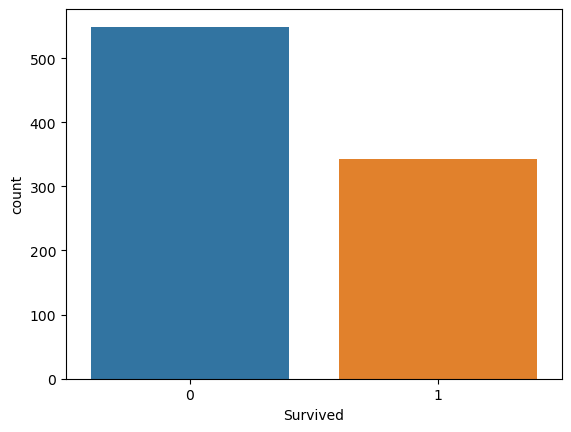

In [ ]:
sns.countplot(data=train_df, x='Survived')

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

<Axes: xlabel='Sex', ylabel='Age'>

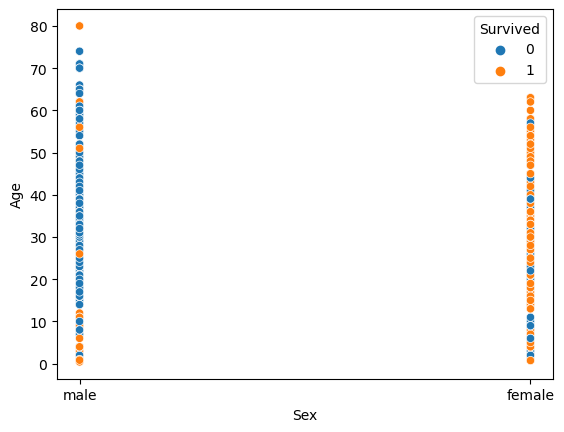

In [ ]:
sns.scatterplot(data=train_df, x='Sex', y='Age', hue='Survived')

**Tratando valores nulos**

In [ ]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Preenchendo nulos do campo idade pela média do dataset**

In [ ]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace = True)

Substituindo classificação do gênero "male" x "female":
*   male = 0
*   famele =1

In [ ]:
train_df['Sex']=train_df['Sex'].replace('male', 0)
train_df['Sex']=train_df['Sex'].replace('female', 1)

**Removendo colunas que não serão usadas no modelo**

In [ ]:
train_df.drop(['Name', 'PassengerId', 'Fare', 'Ticket','Embarked', 'Cabin'], axis = 1, inplace = True)

**Não sobra nenhum valor nulo**

In [ ]:
train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
dtype: int64

**Checando se sobraram valores nulos**

In [ ]:
missing=train_df.isnull().sum().sort_values(ascending=False)
missing=missing.drop(missing[missing==0].index)
missing

Series([], dtype: int64)

**Definiando variável alvo para o eixo Y (predição) e removendo ela do eixo X (preditores)**

In [ ]:
X= train_df.drop('Survived', axis=1)
y= train_df['Survived']

**Dividindo o dataset para trabalhar com treino e teste (70 x 30)**

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**Realizando pré-processamento para deixar os dados em escala semelhante**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


StandardScaler()

In [ ]:
scaled_X_train= scaler.transform(X_train)
scaled_X_test= scaler.transform(X_test)

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and

**Treinando o modelo**

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model= LogisticRegression()
logistic_model.fit(scaled_X_train, y_train)

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression()

In [ ]:
logistic_model.coef_

array([[-0.93907697,  1.30757216, -0.47770544, -0.32733646, -0.0530102 ]])

In [ ]:
y_pred= logistic_model.predict(scaled_X_test)

**Avaliando os resultados (sem usar o arquivo test.csv por enquanto)**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

accuracy_score(y_test, y_pred)

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isin

0.7761194029850746

In [ ]:
confusion_matrix(y_test, y_pred)

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isin

array([[133,  21],
       [ 39,  75]])

/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isin

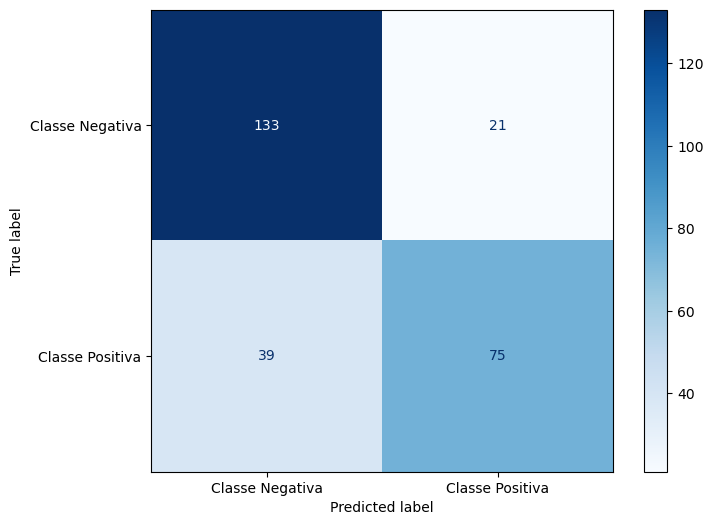

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe Negativa', 'Classe Positiva'])

# Plota matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       154
           1       0.78      0.66      0.71       114

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.77       268



/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/miniconda3/envs/jupyter/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isin

**Exportando modelo para salvar no S3**

In [ ]:
from joblib import dump, load
dump(logistic_model, 'titanic_logistic_model.joblib')

['titanic_logistic_model.joblib']

In [ ]:
s3_client = boto3.client(service_name='s3')

In [ ]:
response = s3_client.list_buckets()

In [ ]:
response['Buckets']

[]

In [ ]:
response = s3_client.create_bucket(Bucket="ygor-bucket-test")

In [ ]:
response['ResponseMetadata']['HTTPStatusCode']

200

In [ ]:
s3_client.upload_file("./titanic_logistic_model.joblib", "ygor-bucket-test", "titanic_logistic_model.joblib")

**URL Pública Gerada no S3:** https://ygor-bucket-test.s3.amazonaws.com/titanic_logistic_model.joblib

In [ ]:
response = s3_client.delete_object(Bucket="ygor-bucket-test", Key="titanic_logistic_model.joblib")

In [ ]:
response = s3_client.delete_bucket(Bucket="ygor-bucket-test")